In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import os.path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import tensorflow as tf

In [2]:
def get_paths_labels(path, allowed_extension="jpg"):
        global Path
        images_dir = Path(path)
        
        filepaths = pd.Series((images_dir.glob(fr'**/*.{allowed_extension}'))).astype(str)
        filepaths.name = "path"
        labels = filepaths.str.split("\\")[:].str[-2]
        labels.name = "label"

        # Concatenate filepaths and labels
        df = pd.concat([filepaths, labels], axis=1)

        # Shuffle the DataFrame and reset index
        df = df.sample(frac=1).reset_index(drop = True)
        return df


def get_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def visualize_samples(datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    images = filepaths.apply(get_image).reset_index(drop=True)
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(labels[sample_index])
            ax[i,j].set_axis_off()
    plt.show()

def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = tf.keras.applications.mobilenet.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

def visualize_classifications(model, datagen, row_col_len=4, figsize=None):
    random_indexes = np.random.randint(0, len(datagen.labels), row_col_len**2)
    
    classes = np.array(list(datagen.class_indices))
    labels = classes[np.array(datagen.labels)[random_indexes]]
    filepaths = pd.Series(datagen.filenames)[random_indexes]
    
    images = filepaths.apply(get_image).reset_index(drop=True)
    processed_images = np.vstack(images.apply(process).to_numpy()[:])
    
    y_pred = classes[np.argmax(model.predict(processed_images, verbose=0), axis=1)]
    y_true = labels
    
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len, row_col_len, figsize=figsize)
    
    for i in range(row_col_len):
        for j in range(row_col_len):
            sample_index = i * row_col_len + j
            ax[i,j].imshow(images[sample_index])
            ax[i,j].set_title(f"Y true({y_true[sample_index]}) | Y pred ({y_pred[sample_index]})")
            ax[i,j].set_axis_off()
    plt.show()

In [3]:
train_df = get_paths_labels('E:/Extra Codes/Python/Python Projects/Hand Sign Recognition/Data/ASL DATA')

train_df

path label
0      E:\Extra Codes\Python\Python Projects\Hand Sig...     T
1      E:\Extra Codes\Python\Python Projects\Hand Sig...     C
2      E:\Extra Codes\Python\Python Projects\Hand Sig...     E
3      E:\Extra Codes\Python\Python Projects\Hand Sig...     D
4      E:\Extra Codes\Python\Python Projects\Hand Sig...     J
...                                                  ...   ...
11055  E:\Extra Codes\Python\Python Projects\Hand Sig...     D
11056  E:\Extra Codes\Python\Python Projects\Hand Sig...     X
11057  E:\Extra Codes\Python\Python Projects\Hand Sig...     P
11058  E:\Extra Codes\Python\Python Projects\Hand Sig...     K
11059  E:\Extra Codes\Python\Python Projects\Hand Sig...     Y

[11060 rows x 2 columns]

In [4]:
print("Classes counts")
counts = train_df.iloc[:,1].value_counts().sort_index()
print(counts.head(counts.shape[0]))
print(f"\n\nDataset size = {counts.sum()} samples")

Classes counts
A     200
B     200
C     200
D     622
E     200
F     576
G     200
H     332
I     675
J     462
K     403
L     404
M     467
N     600
O     200
P     701
Q     200
R    1016
S     200
T     671
U     202
V     752
W     210
X     200
Y     550
Z     617
Name: label, dtype: int64


Dataset size = 11060 samples


In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 8848 validated image filenames belonging to 26 classes.
Found 2212 validated image filenames belonging to 26 classes.


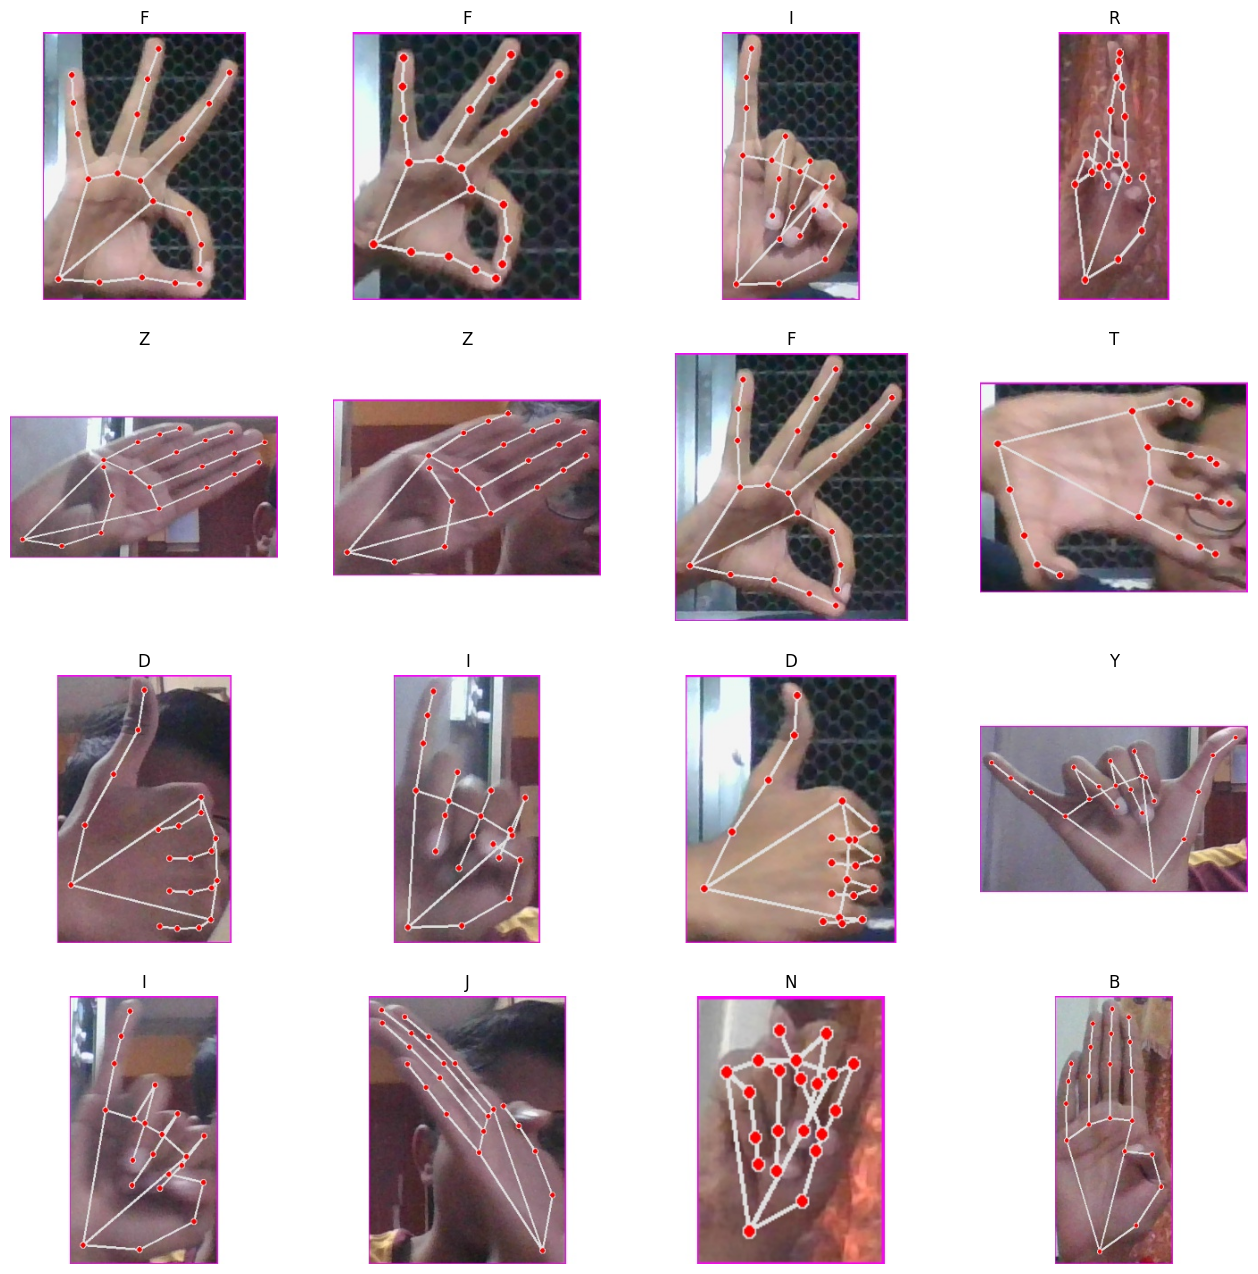

In [6]:
visualize_samples(train_images)

All the hand Signs


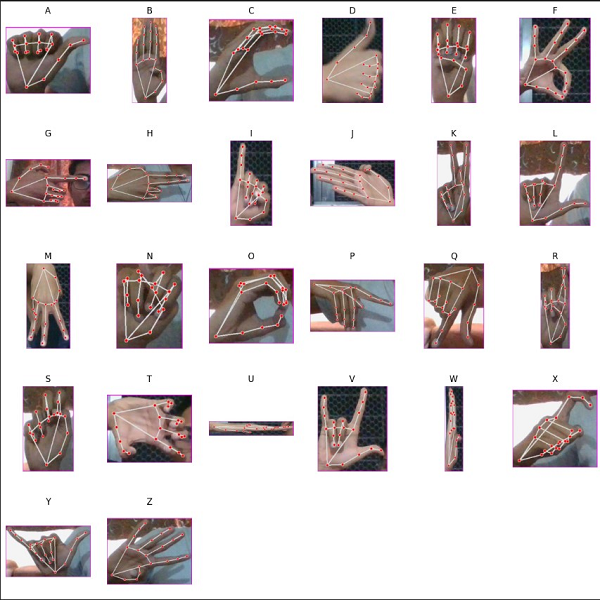

In [2]:
print("All the hand Signs")
display(Image(filename='E:/Extra Codes/Python/Python Projects/Hand Sign Recognition/Images_Hand_Signs_Tutorials/ASL_Hand_Signs_1.png'))

In [7]:
Model = tf.keras.applications.MobileNet(
    input_shape=(224, 224, 3),
     include_top=False,
     weights='imagenet',
     pooling='avg'
)
Model.trainable = False

inputs = Model.input
x = tf.keras.layers.Dense(128, activation='relu')(Model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(26, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer_adam = tf.keras.optimizers.Adam(learning_rate = 0.005)

In [8]:
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
 )

Epoch 1/2
139/139 [==============================] - 355s 3s/step - loss: 0.4344 - accuracy: 0.8808 - val_loss: 0.0614 - val_accuracy: 0.9733
Epoch 2/2
139/139 [==============================] - 239s 2s/step - loss: 0.0470 - accuracy: 0.9853 - val_loss: 0.0295 - val_accuracy: 0.9892


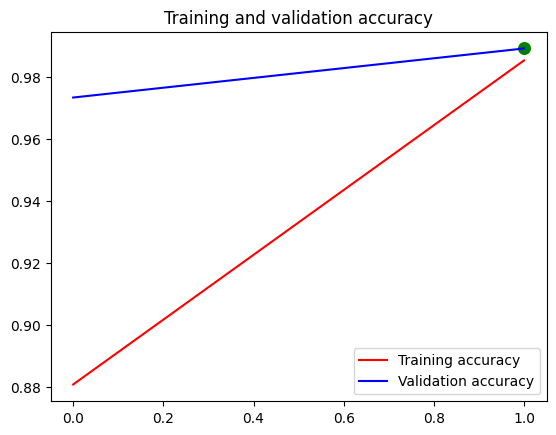

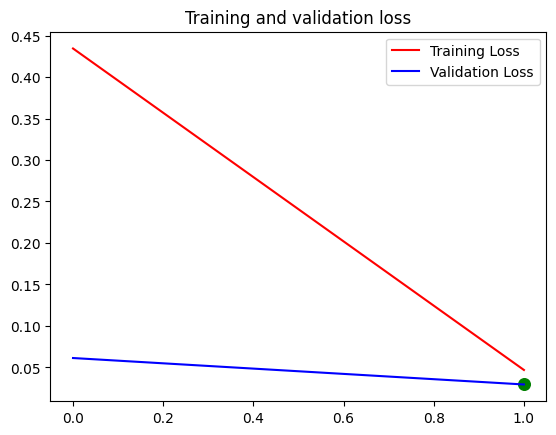

In [10]:
%matplotlib inline
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])
loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs = np.arange(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.scatter(epochs[val_acc.argmax()], val_acc.max(), color='green', s=70)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(epochs[val_loss.argmin()], val_loss.min(), color='green', s=70)
plt.title('Training and validation loss')
plt.legend()

plt.show()

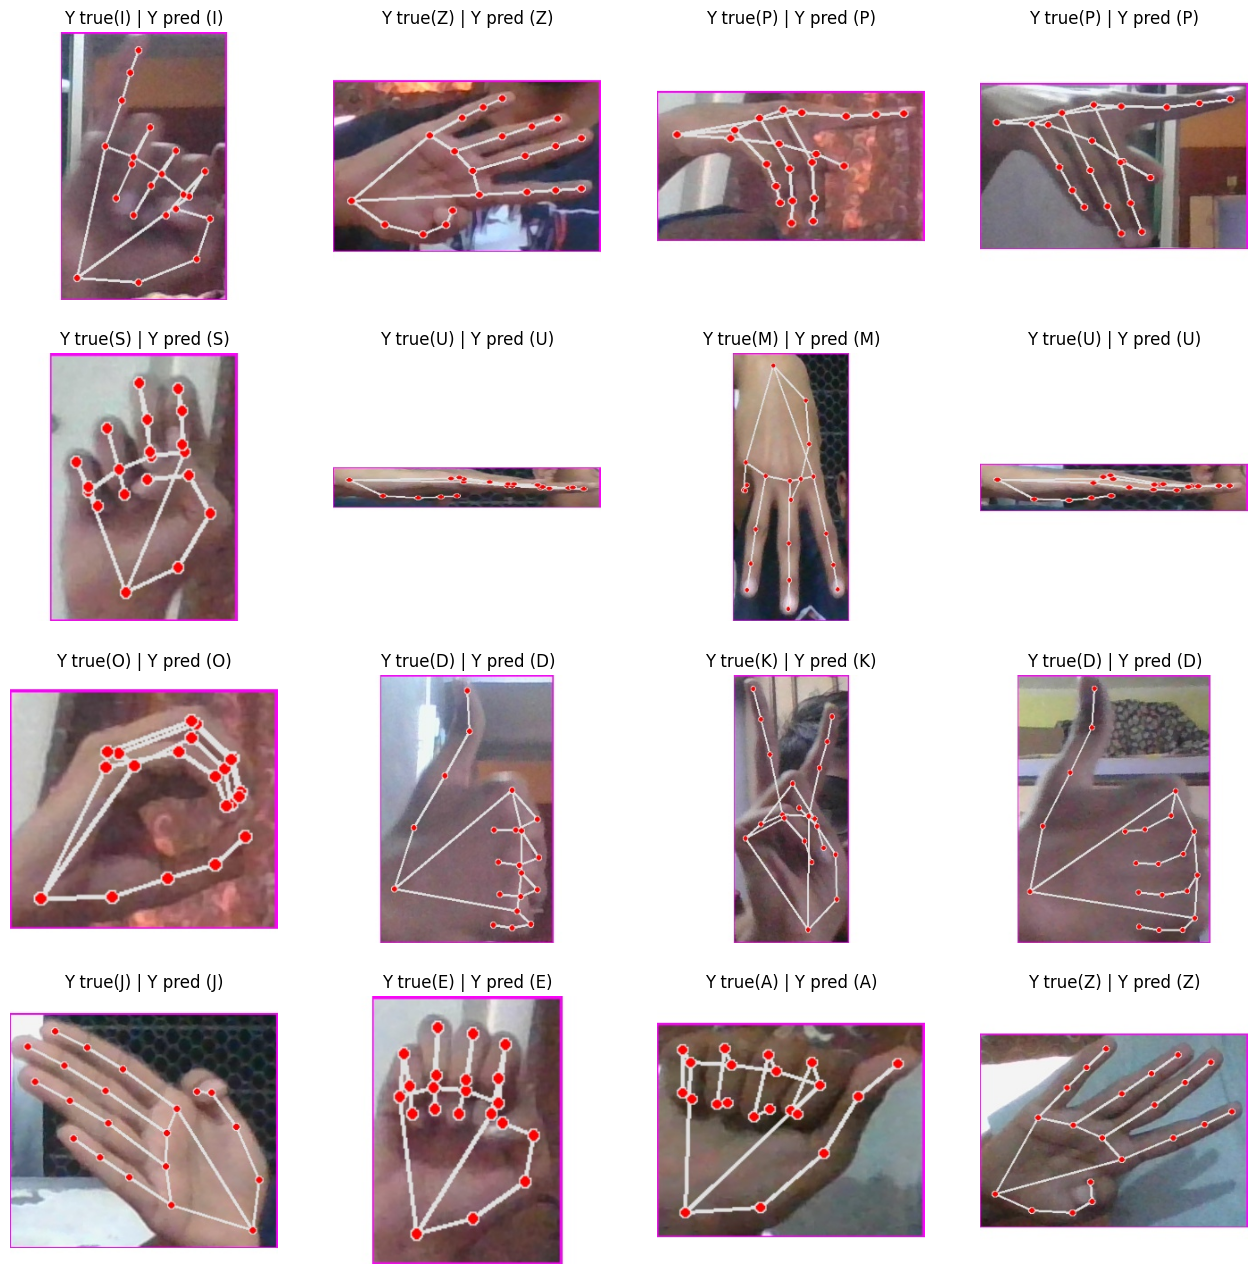

In [11]:
visualize_classifications(model, val_images)

In [17]:
model.save('E:/Extra Codes/Python/Python Projects/Hand Sign Recognition/Model/CNN_Custom_Model_1/Sign Language ASL Classifier.h5')